In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [2]:
# === Load Data ===
DATA_DIRS = [
    "Datasets/Vitiligo",
    "Datasets/Rashes",
    "Datasets/Lupus",
    "Datasets/Acne"
]

IMG_SIZE = (128, 128)

def load_images_from_folders(data_dirs, img_size):
    X, y = [], []
    class_mapping = {}
    label_index = 0

    for data_dir in data_dirs:
        label = os.path.basename(data_dir)

        if label not in class_mapping:
            class_mapping[label] = label_index
            label_index += 1

        for img_name in os.listdir(data_dir):
            img_path = os.path.join(data_dir, img_name)
            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            X.append(img)
            y.append(class_mapping[label])

    return np.array(X) / 255.0, np.array(y), class_mapping

# Load
X, y, class_mapping = load_images_from_folders(DATA_DIRS, IMG_SIZE)
categories = list(class_mapping.keys())

# Train/Val/Test Split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# One-hot encoding
y_train = to_categorical(y_train, num_classes=4)
y_val = to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)



In [3]:
# === Model: MobileNetV2 Transfer Learning ===
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# === Train ===
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 21s 283ms/step - accuracy: 0.4441 - loss: 1.2691 - val_accuracy: 0.7264 - val_loss: 0.6687 - learning_rate: 1.0000e-04
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.7053 - loss: 0.7203 - val_accuracy: 0.7612 - val_loss: 0.5567 - learning_rate: 1.0000e-04
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.7632 - loss: 0.5584 - val_accuracy: 0.7960 - val_loss: 0.5144 - learning_rate: 1.0000e-04
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 248ms/step - accuracy: 0.7873 - loss: 0.5094 - val_accuracy: 0.7910 - val_loss: 0.4817 - learning_rate: 1.0000e-04
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 246ms/step - accuracy: 0.8133 - loss: 0.4581 - val_accuracy: 0.8159 - val_loss: 0.4631 - learning_rate: 1.0000e-04
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 12s 240ms/step - accuracy: 0.8099 - loss: 0.4308 - val_accuracy: 0.8109 - val_loss: 0.4529 - learning_rate: 1.0000e-04
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - acc

In [4]:
# === Fine-tuning ===
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history_finetune = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop, reduce_lr]
)


Epoch 1/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 413ms/step - accuracy: 0.6853 - loss: 0.8147 - val_accuracy: 0.8109 - val_loss: 0.4732 - learning_rate: 1.0000e-05
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 355ms/step - accuracy: 0.7984 - loss: 0.4793 - val_accuracy: 0.7910 - val_loss: 0.5646 - learning_rate: 1.0000e-05
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 347ms/step - accuracy: 0.8374 - loss: 0.3834 - val_accuracy: 0.7910 - val_loss: 0.5715 - learning_rate: 1.0000e-05
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 395ms/step - accuracy: 0.8560 - loss: 0.3551 - val_accuracy: 0.7910 - val_loss: 0.6029 - learning_rate: 1.0000e-05
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 19s 365ms/step - accuracy: 0.8741 - loss: 0.3211 - val_accuracy: 0.7910 - val_loss: 0.6032 - learning_rate: 5.0000e-06
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 18s 344ms/step - accuracy: 0.8813 - loss: 0.2983 - val_accuracy: 0.7861 - val_loss: 0.5861 - learning_rate: 5.0000e-06


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 241ms/step - accuracy: 0.8569 - loss: 0.4067
Test Accuracy: 0.86
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 457ms/step
=== Classification Report ===
              precision    recall  f1-score   support

    Vitiligo       0.96      0.93      0.95        56
      Rashes       0.69      0.88      0.77        48
       Lupus       0.78      0.57      0.66        44
        Acne       0.98      1.00      0.99        54

    accuracy                           0.86       202
   macro avg       0.85      0.84      0.84       202
weighted avg       0.86      0.86      0.85       202



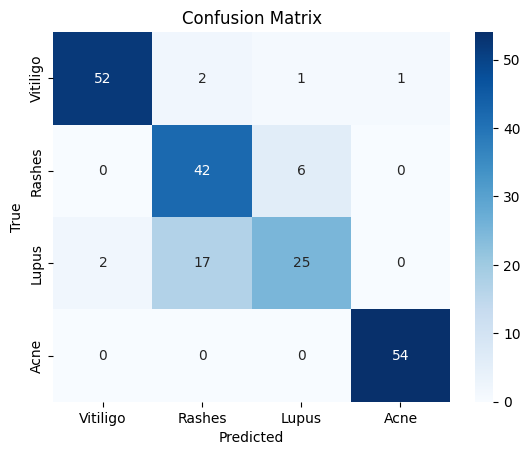

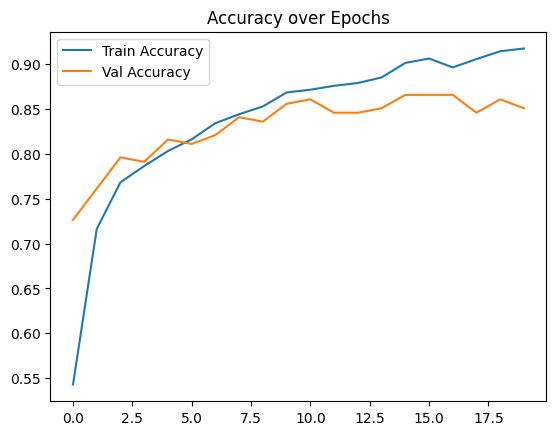

In [5]:
# === Evaluate ===
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")

# === Classification Report & Confusion Matrix ===
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("=== Classification Report ===")
print(classification_report(y_true, y_pred_classes, target_names=categories))

cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=categories, yticklabels=categories, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# === Accuracy Plot ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()


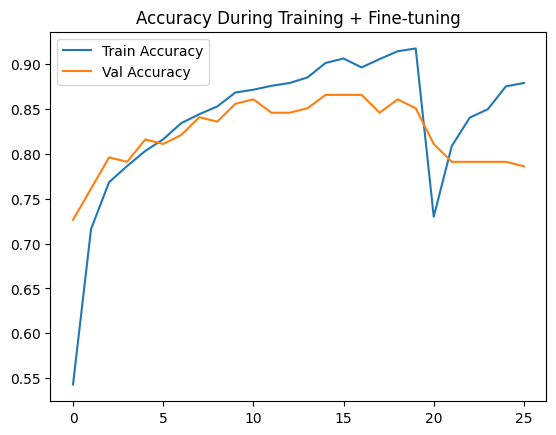

In [6]:
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Accuracy During Training + Fine-tuning')
plt.show()


In [8]:
model.save('Skin_disease_Predictor_model.keras')